In [32]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)


In [36]:
dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from 0 V to 5 V


In [37]:
volt_in = np.arange(0.44, 4.0, 0.1)
volt_out_list = []

adc_raw=[]
for addr_fifo in range(12):
    print(addr_fifo, end='->')
    data = dut.calibrate_adc(volt_in, addr_fifo=addr_fifo )
    volt_out_list.append( [dut.adc2volt(d) for d in data] )
    adc_raw.append(data)

0->1->2->3->4->5->6->7->8->9->10->11->

Text(0, 0.5, 'Quality number')

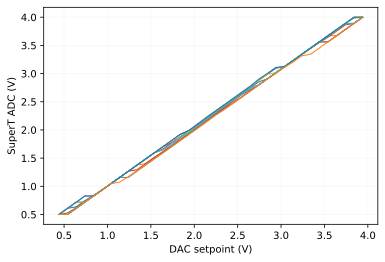

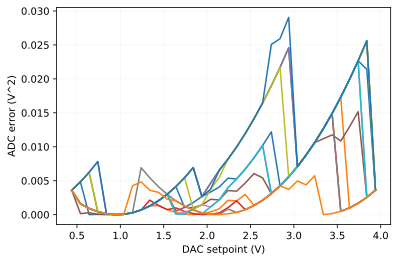

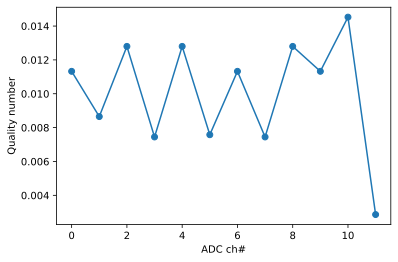

In [38]:
volt_out_list = np.array(volt_out_list)

adc_quality = []

plt.figure(1)
plt.xlabel('DAC setpoint (V)')
plt.ylabel('SuperT ADC (V)')
plt.grid(True, alpha=0.1)

for i, volt_out in enumerate(volt_out_list):
    plt.figure(1)
    plt.plot(volt_in, volt_out, linewidth=1)
    
    voffset=0
    volt_err2 = []
    for vin, vout in zip(volt_in, volt_out):
        volt_err2.append( (vout-vin -voffset)**2 )
    volt_err2 = np.array(volt_err2)
    adc_quality.append( (np.max(volt_err2) - np.min(volt_err2))/2 )
        
    plt.figure(2)
    plt.plot(volt_in, volt_err2)

plt.grid(True, alpha=0.1)
plt.xlabel('DAC setpoint (V)')
plt.ylabel('ADC error (V^2)')
    
plt.figure(3)
plt.plot(range(12), adc_quality, 'o-')
plt.xlabel('ADC ch#')
plt.ylabel('Quality number')

5.00-

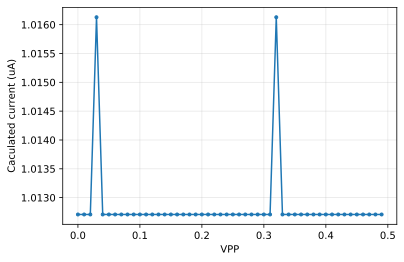

In [39]:
# ar=2
# r=31
# c=0
ar=0
r=30
c=30


Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

dut.dac_set('DAC_VREF_HI_CMP', 4.92)

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1) )
    volts_set.append(volts)

dut.dac_set('DAC_VREF_HI_CMP', 3.92)

for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

5.00-

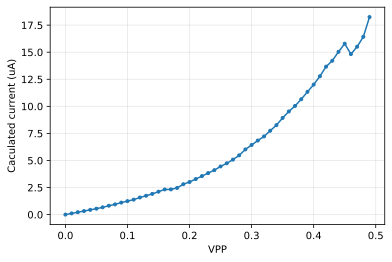

In [40]:
ar=2
r=31
c=0
# ar=1
# r=3
# c=63


Vreads = np.arange(0, 0.5, 0.01)
Vgates = [5]

volts_set = []

dut.dac_set('DAC_VREF_HI_CMP', 3.92)

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1) )
    volts_set.append(volts)

dut.dac_set('DAC_VREF_HI_CMP', 3.92)

for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

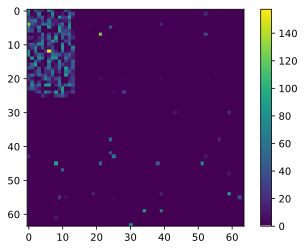

In [97]:
Gmap = a0.pic_read_batch(1, gain=-1, Vread=0.2) / 0.2
plt.imshow(Gmap* 1e6)
plt.colorbar()

In [94]:
data = a0.pic_read_batch(1, gain=-1, raw=True) 

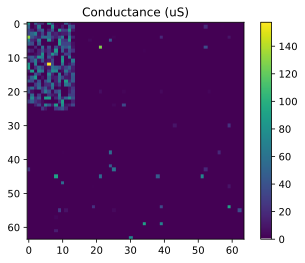

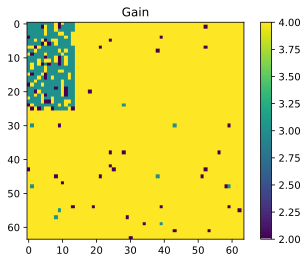

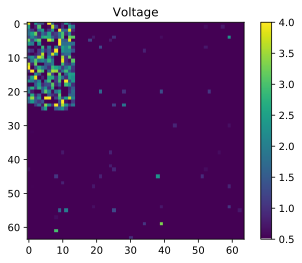

In [100]:
curr = a0.adc2current_array(data, 0.5)
gain = data >>10
volts = dut.adc2volt(data)


plt.figure(1)
plt.title('Conductance (uS)')
plt.imshow(curr/0.2 * 1e6)
plt.colorbar()
# plt.clim(0, 100)

plt.figure(2)
plt.title('Gain')
plt.imshow(gain)
plt.colorbar()

plt.figure(3)
plt.title('Voltage')
plt.imshow(volts)
plt.colorbar()

In [52]:
adc_raw = a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1, raw=True)
print(f'{adc_raw:013b}')

volt = dut.adc2volt(adc_raw)
print(f'{volt:.4f} V')

gain = adc_raw >> 10
print(f'gain = {gain:d}')

curr = a0.adc2current(adc_raw, 0.5)
print(f'curr = {curr*1e6:.4f} uA')

0100010100000
1.0474 V
gain = 2
curr = 18.2470 uA


In [8]:
adc_raw = a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1, raw=True)
print(f'{adc_raw:013b}')

volt = dut.adc2volt(adc_raw)
print(f'{volt:.4f} V')

gain = adc_raw >> 10
print(f'gain = {gain:d}')

curr = a0.adc2current(adc_raw, 0.5)
print(f'curr = {curr*1e6:.4f} uA')

0100010110000
1.1022 V
gain = 2
curr = 20.0717 uA


0.4683816432952881


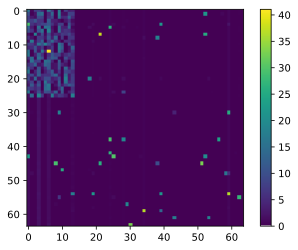

In [103]:
input = [0x1<<i for i in range(64)]

gn=-1
Vr=0.2

ts = time.time()

data = np.zeros((64,64))
a0.pic_read_config(gain=gn, Vread=Vr)

for i in range(64):
    data[i] = a0.pic_dpe_batch(1, [input[i]], skip_conf=True, mode=0, gain=gn) 
    time.sleep(0.005)
    
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()
# plt.clim(0,0.0001)

0.14107131958007812


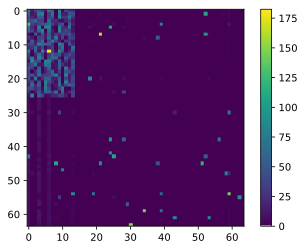

In [105]:
input = [0x1<<i for i in range(64)]
ts = time.time()
data = a0.pic_dpe_batch(1, input, gain=-1, Vread=0.2, mode=1) / 0.2
print(time.time()-ts)
plt.imshow(data * 1e6)
plt.colorbar()

3.0314486026763916


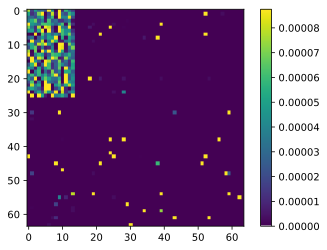

In [24]:
ts = time.time()
Gmap = np.zeros((64, 64))
arr = 1
gn=-2
Vr=0.2

a0.pic_read_config(gain=gn, Vread=Vr)

# time.sleep(0.01)

for r in range(64):
    for c in range(64):
        drv.spi_serial_write(2, bytes([0x10, 0x02, 0x0c, 0x10, 0x0c, 0x01, 0x02]))
        value = a0.pic_read_single(arr, r, c, skip_conf=True, gain=gn)
        Gmap[r,c] = value / Vr
#         time.sleep(0.005)
        
print(time.time()-ts)

plt.imshow(Gmap)
plt.colorbar()

33.4279522895813


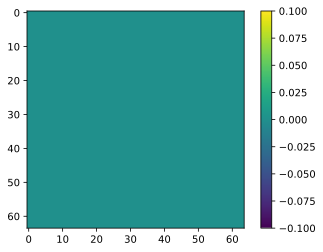

In [37]:
ts = time.time()
Gmap = np.zeros((64, 64))
arr = 1
gn=0
Vr=0.2

a0.pic_read_config(gain=gn, Vread=Vr)

time.sleep(0.01)

for r in range(64):
    for c in range(64):
#         drv.spi_serial_write(2, bytes([0x10, 0x02, 0x0c, 0x10, 0x0c, 0x01, 0x02]))
        value = a0.pic_read_single(arr, r, c, skip_conf=True, gain=gn)
        Gmap[r,c] = value / Vr
        time.sleep(0.005)
        
print(time.time()-ts)

plt.imshow(Gmap)
plt.colorbar()